# Tutorial: Data as Objects and Tidy Data

## Goals:
* Learn about Tidy Data, long data, and wide data
* Learn how to interact with model objects in R, including extracting coefficients

---
# Tidy Data

When you are working with data frames, it is best practice to keep your data **tidy**. **Tidy data** is a very specific term in which the following are true:

* Columns are variables
* Rows are individual observations
* Observation for each variable is stored in the corresponding cell

There are two versions of the tidy data format - long and wide. To illustrate the difference, imagine a repeated measures dataset, where you gather four observations for each subject at four different time points. In the **long data** format, each row represents an **observation** at a specific timepoint for a specific subject. Each subject has multiple rows of observations. The columns will be *subject*, *timepoint*, and *observation*. For example:

In [ ]:
long_data <- data.frame(subject = rep(1:3, each=4),  # rep repeats a vector n times
                        timepoint = rep(1:4, times=3), # same as previous
                        observation = round(rnorm(12), 2)) #rnorm simulates a normal distribution
long_data # print out long data table

subject,timepoint,observation
<int>,<int>,<dbl>
1,1,-1.09
1,2,0.10
1,3,0.84
1,4,1.09
2,1,-0.81
2,2,-0.13
2,3,0.76
2,4,-0.44
3,1,2.09


Alternatively, the data can be organized in a **wide format**, in which each row is a single **subject**, the four different timepoints are represented as different columns, and the observation for each timepoint is stored at a cell within that column. Like this (don't worry about the code for now, it is explained in the next tutorial):

In [ ]:
library(tidyverse) #We'll learn about this package in the next tutorial!

long_data  %>% # This is a pipe. We will learn about this later
    mutate(timepoint = paste0('time',timepoint))  %>%  # mutate makes a new column
    spread(timepoint, observation) # spread pushes an observation across multiple columns

subject,time1,time2,time3,time4
<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1.09,0.10,0.84,1.09
2,-0.81,-0.13,0.76,-0.44
3,2.09,-1.62,0.95,-0.09


---
# Interacting with model objects in R

Whenever you run a regression or any other type of model, the resulting model is saved in an **object** with properties you can access. This is handy for fitting a model once, and then referencing different aspects of that model's performance and fit. Let's see an example:

In [ ]:
# generate data where y is a function of two variables, x1 and x2
x1 <- seq(-4,4,0.5) #generate data ranging from -4 to 4 in steps of 0.5
x2 <- seq(-4,4,0.5)

#specify a sigmoidal relationship between x1 and y
#and a linear relationship between x2 and y
dat <- expand.grid(x1=x1, x2=x2) %>%
    mutate(y = 1/(1+exp(-x1)) + 0.1*x2)

head(dat)

,x1,x2,y
,<dbl>,<dbl>,<dbl>
1,-4.0,-4,-0.3820138
2,-3.5,-4,-0.3706878
3,-3.0,-4,-0.3525741
4,-2.5,-4,-0.3241418
5,-2.0,-4,-0.2807971
6,-1.5,-4,-0.2175745


Note that `expand.grid` just creates a data frame with all possible pairs of the input variables. So here, each value of `x1` was paired with an `x2` value of -4, then with an `x2` value of -3.5, etc...

We'll learn more about the pipe (%>%) and `mutate` in the next tutorial!

Here is how y depends on x1 and x2:

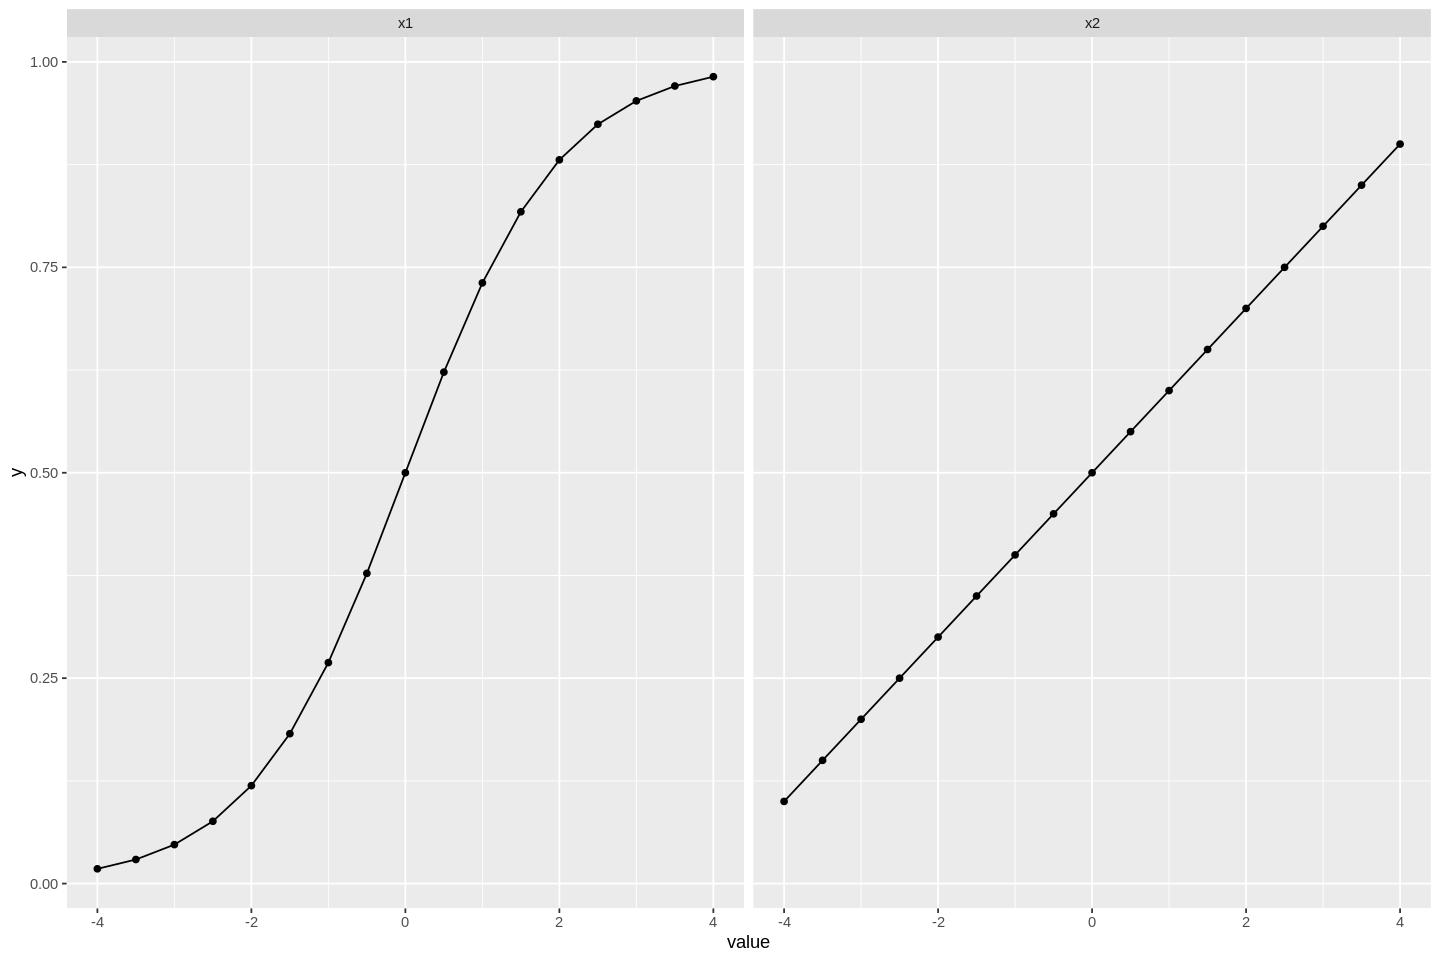

In [ ]:
# setting figure size
options(repr.plot.width=12, repr.plot.height=8)

dat  %>%
    gather(var, value, x1, x2) %>% # make it long format - only x1 or x2 in each row
    ggplot(aes(value, y)) + # we will learn aboug ggplot in a later tutorial
    stat_summary(geom='point',fun=mean) +
    stat_summary(geom='line',fun=mean) +
    facet_wrap(~var) # optimally wraps figures as needed


Now, let's add some noise and try to fit a regression model

In [ ]:
#create new y_obs variable with normally distributed noise
dat <- mutate(dat, y_obs = y + rnorm(length(y), mean=0, sd=0.1))

#fit a linear model to find the regression coefficients
model_fit <- lm(y_obs ~ x1 + x2, data=dat)

The resulting model is saved in the `model_fit` variable. This is the "model object", and you can do a number of things with it. First, the `str()` command, which is a general function for printing the structure of r objects, will tell you what you can find in the model object. As you can see below, it is a list of different variables, which you can access by typing the name of the model, followed by `$variable`.

In [ ]:
str(model_fit) #print the structure of the model object

List of 12
 $ coefficients : Named num [1:3] 0.4996 0.1507 0.0999
  ..- attr(*, "names")= chr [1:3] "(Intercept)" "x1" "x2"
 $ residuals    : Named num [1:289] 0.0767 0.1405 0.0611 -0.0984 -0.0678 ...
  ..- attr(*, "names")= chr [1:289] "1" "2" "3" "4" ...
 $ effects      : Named num [1:289] -8.4925 6.2743 4.1608 -0.1134 -0.0814 ...
  ..- attr(*, "names")= chr [1:289] "(Intercept)" "x1" "x2" "" ...
 $ rank         : int 3
 $ fitted.values: Named num [1:289] -0.503 -0.427 -0.352 -0.277 -0.201 ...
  ..- attr(*, "names")= chr [1:289] "1" "2" "3" "4" ...
 $ assign       : int [1:3] 0 1 2
 $ qr           :List of 5
  ..$ qr   : num [1:289, 1:3] -17 0.0588 0.0588 0.0588 0.0588 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:289] "1" "2" "3" "4" ...
  .. .. ..$ : chr [1:3] "(Intercept)" "x1" "x2"
  .. ..- attr(*, "assign")= int [1:3] 0 1 2
  ..$ qraux: num [1:3] 1.06 1.08 1.09
  ..$ pivot: int [1:3] 1 2 3
  ..$ tol  : num 1e-07
  ..$ rank : int 3
  ..- attr(*, "class")= chr "q

For example, if we want to extract the estimated regression coefficients, we can type this, which returns a named vector.

In [ ]:
model_fit$coefficients

(Intercept)          x1          x2 
 0.49955992  0.15067549  0.09991912

If we run multiple models, we might want to store these values in a data.frame, rather than a named vector like this:

In [ ]:
#store the coefficients in a variable
coef <- model_fit$coefficients

#save the name/value of the coefficients in a dataframe
data.frame(name = names(coef), value = coef)

,name,value
,<chr>,<dbl>
(Intercept),(Intercept),0.49955992
x1,x1,0.15067549
x2,x2,0.09991912


You can also extract the prediction of the model. They are stored under `$fitted.values`, or you can get them by typing `fitted(model_fit)`, which returns the same values. Then, we can plot the observed values against the predicted values:

In [ ]:
#extract model estimate of y for each x and store in df as fitted
dat$fitted <- model_fit$fitted.values

head(dat) #we see "fitted" column added

,x1,x2,y,y_obs,fitted
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-4.0,-4,-0.3820138,-0.4261378,-0.5028185
2,-3.5,-4,-0.3706878,-0.2869985,-0.4274808
3,-3.0,-4,-0.3525741,-0.2910417,-0.3521430
4,-2.5,-4,-0.3241418,-0.3752198,-0.2768053
5,-2.0,-4,-0.2807971,-0.2692938,-0.2014675
6,-1.5,-4,-0.2175745,-0.2070880,-0.1261298


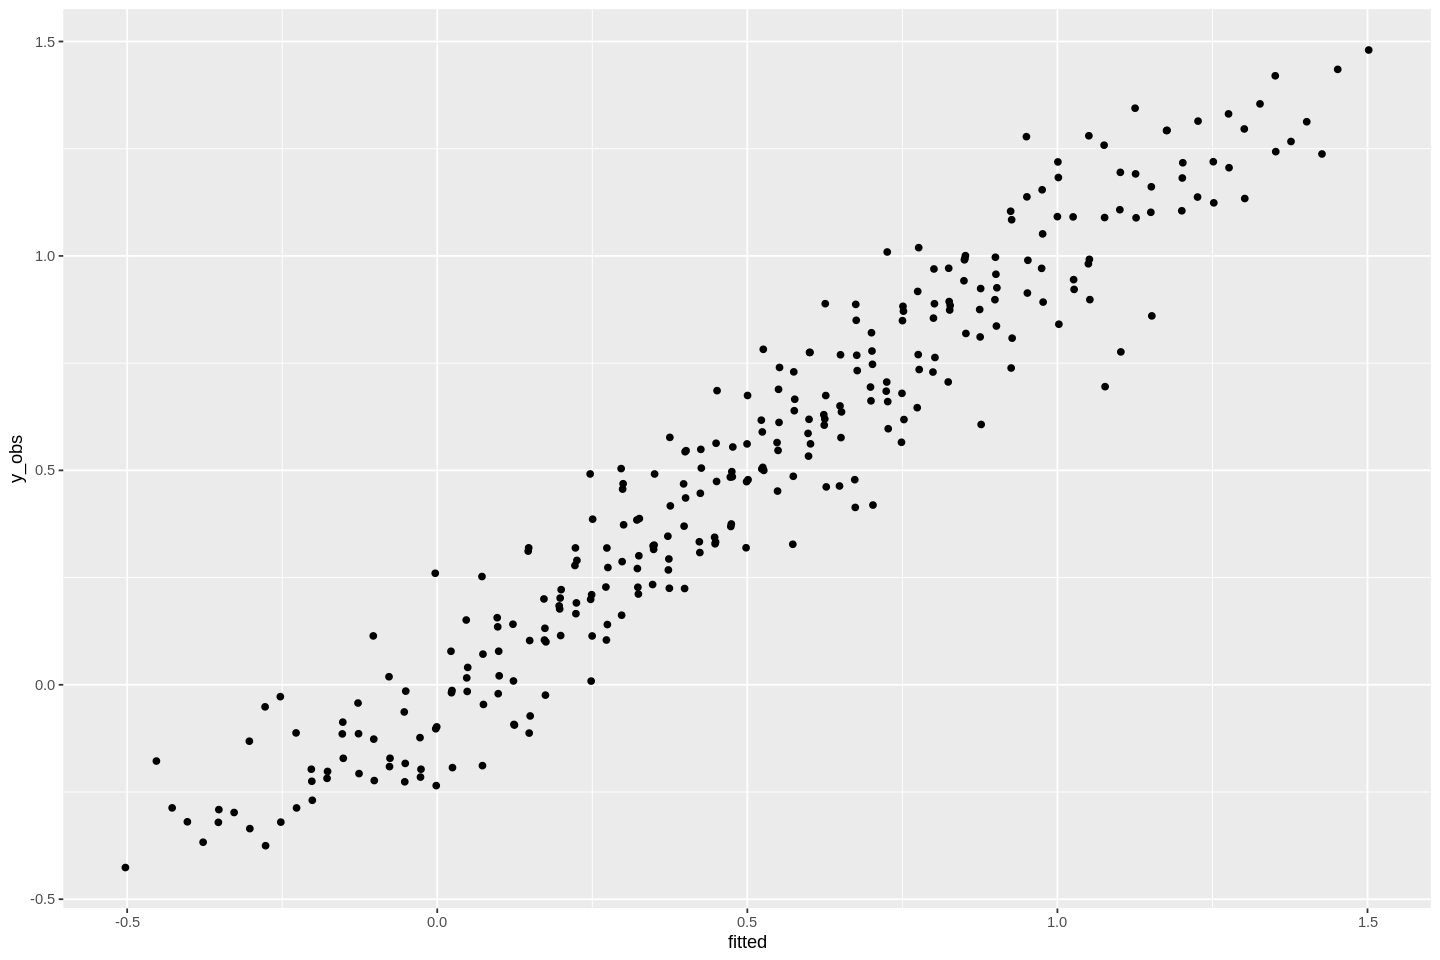

In [ ]:
#plot fitted against the observed data
ggplot(dat, aes(fitted, y_obs)) +
    stat_summary(geom='point',fun=mean)

Given your fitted model, you can also easily generate predictions of y given new values of x using the `predict` function:

In [ ]:
new_data <- data.frame(x1=-5, x2=10) #new x-values to give to the model
predict(model_fit, newdata = new_data) #predict the y value for a given x

1 
0.7453737

That's all for now! We'll dive into some more advanced functions for data manipulation in R in the next tutorial.

*Notebook authored by Ven Popov and edited by Krista Bond, Charles Wu, Patience Stevens, Amy Sentis, and Fiona Horner.*